## Hybrid Retriever- Combining Dense And Sparse Retriever

In [1]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.retrievers import BM25Retriever #sparse matrix
from langchain_classic.retrievers import EnsembleRetriever  #combning sparse and dense
from langchain_classic.schema import Document



d:\Udemy_learning\Ultimate_RAG_learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Sample documents
docs = [
    Document(page_content="LangChain helps build LLM applications."),
    Document(page_content="Pinecone is a vector database for semantic search."),
    Document(page_content="The Eiffel Tower is located in Paris."),
    Document(page_content="Langchain can be used to develop agentic ai application."),
    Document(page_content="Langchain has many types of retrievers.")
]

# Step 2: Dense Retriever (FAISS + HuggingFace)
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
dense_vectorstore = FAISS.from_documents(docs, embedding_model)
dense_retriever = dense_vectorstore.as_retriever()

In [3]:
### Sparse Retriever(BM25)
sparse_retriever=BM25Retriever.from_documents(docs)
sparse_retriever.k=3 ##top- k documents to retriever

## step 4 : Combine with Ensemble Retriever
hybrid_retriever=EnsembleRetriever(
    retrievers=[dense_retriever,sparse_retriever],
    weight=[0.7,0.3]
)


In [4]:
hybrid_retriever

EnsembleRetriever(retrievers=[VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000028368796B40>, search_kwargs={}), BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x000002835C3BF5F0>, k=3)], weights=[0.5, 0.5])

In [5]:
# Step 5: Query and get results
query = "How can I build an application using LLMs?"
results = hybrid_retriever.invoke(query)

# Step 6: Print results
for i, doc in enumerate(results):
    print(f"\n🔹 Document {i+1}:\n{doc.page_content}")


🔹 Document 1:
LangChain helps build LLM applications.

🔹 Document 2:
Langchain can be used to develop agentic ai application.

🔹 Document 3:
Langchain has many types of retrievers.

🔹 Document 4:
Pinecone is a vector database for semantic search.


### RAG Pipeline with hybrid retriever

In [6]:
from langchain.chat_models import init_chat_model
from langchain_classic.prompts import PromptTemplate
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from langchain_classic.chains.retrieval import create_retrieval_chain

In [7]:
# Step 5: Prompt Template
prompt = PromptTemplate.from_template("""
Answer the question based on the context below.

Context:
{context}

Question: {input}
""")

## step 6-llm
llm=init_chat_model("openai:gpt-3.5-turbo",temperature=0.2)
llm

ChatOpenAI(profile={'max_input_tokens': 16385, 'max_output_tokens': 4096, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': False, 'structured_output': False, 'image_url_inputs': False, 'pdf_inputs': False, 'pdf_tool_message': False, 'image_tool_message': False, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x000002835EC7AA80>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002835E942720>, root_client=<openai.OpenAI object at 0x000002835E39F9B0>, root_async_client=<openai.AsyncOpenAI object at 0x000002835E7BF7D0>, temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [8]:
### Create stuff Docuemnt Chain
document_chain=create_stuff_documents_chain(llm=llm,prompt=prompt)

## create Full rAg chain
rag_chain=create_retrieval_chain(retriever=hybrid_retriever,combine_docs_chain=document_chain)
rag_chain


RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableBinding(bound=RunnableLambda(lambda x: x['input'])
           | EnsembleRetriever(retrievers=[VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000028368796B40>, search_kwargs={}), BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x000002835C3BF5F0>, k=3)], weights=[0.5, 0.5]), kwargs={}, config={'run_name': 'retrieve_documents'}, config_factories=[])
})
| RunnableAssign(mapper={
    answer: RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
              context: RunnableLambda(format_docs)
            }), kwargs={}, config={'run_name': 'format_inputs'}, config_factories=[])
            | PromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, template='\nAnswer the question based on the context below.\n\nContext:\n{context}\n\nQuestion: {input}\n')
            | ChatOpenAI(profile

In [14]:
# Step 9: Ask a question
query = {"input": "How can I build an app using LLMs?"}
response = rag_chain.invoke(query)

# Step 10: Output
print("✅ Answer:\n", response["answer"])

print("\n📄 Source Documents:")
for i, doc in enumerate(response["context"]):
    print(f"\nDoc {i+1}: {doc.page_content}")

✅ Answer:
 You can build an app using LLMs by utilizing LangChain, which helps in developing LLM applications. LangChain can be used to develop agentic AI applications, and it offers various types of retrievers to enhance the functionality of your app. Additionally, you can also consider using Pinecone, a vector database for semantic search, to further improve the performance of your LLM-based app.

📄 Source Documents:

Doc 1: LangChain helps build LLM applications.

Doc 2: Langchain can be used to develop agentic ai application.

Doc 3: Langchain has many types of retrievers.

Doc 4: Pinecone is a vector database for semantic search.


Did some visualization the space how it looks like.

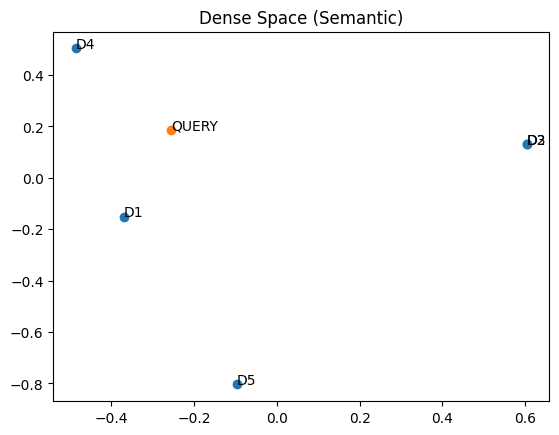

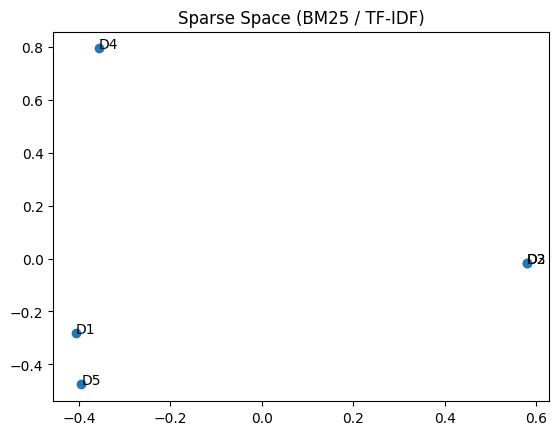

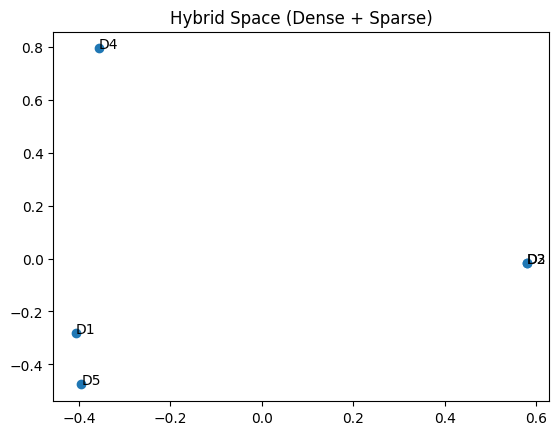

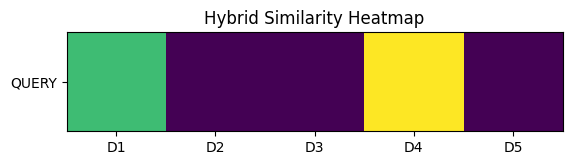

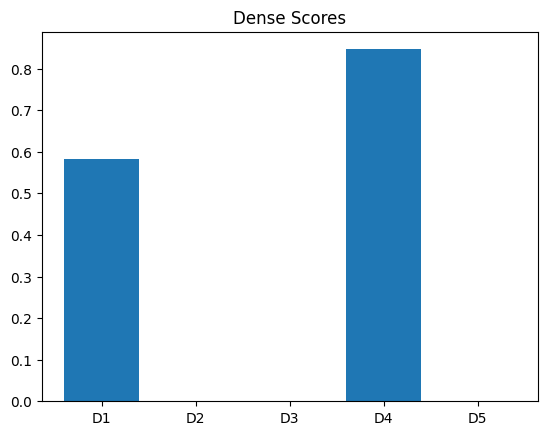

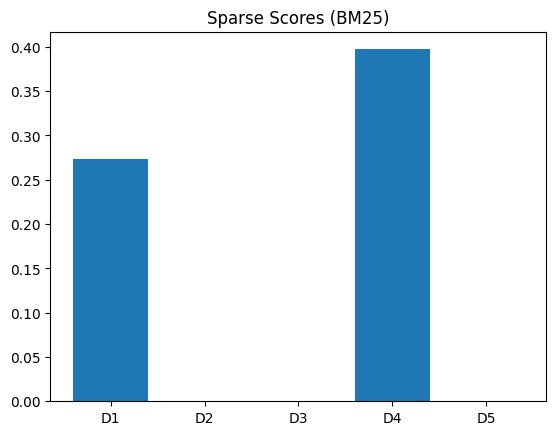

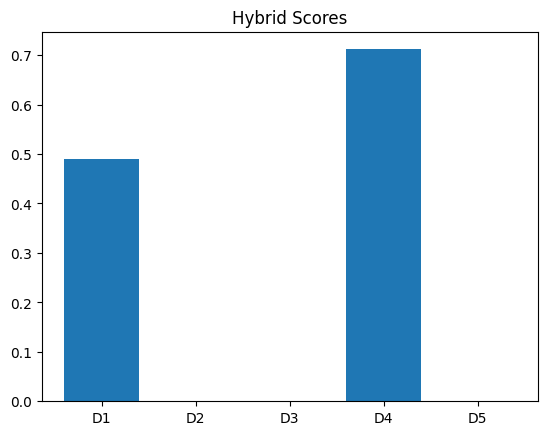

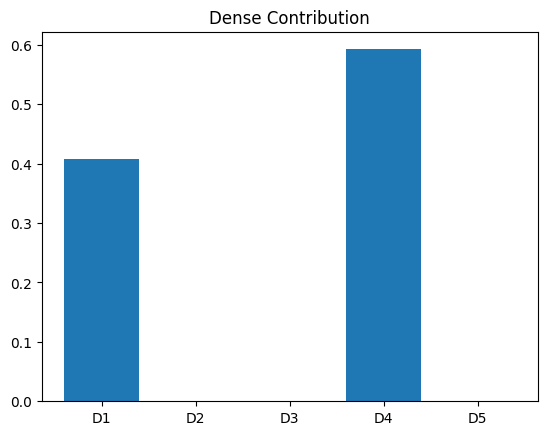

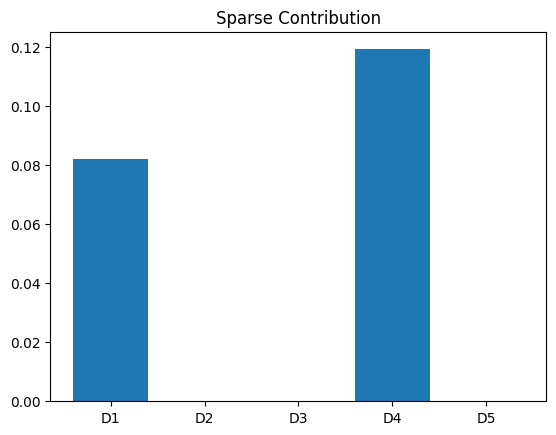

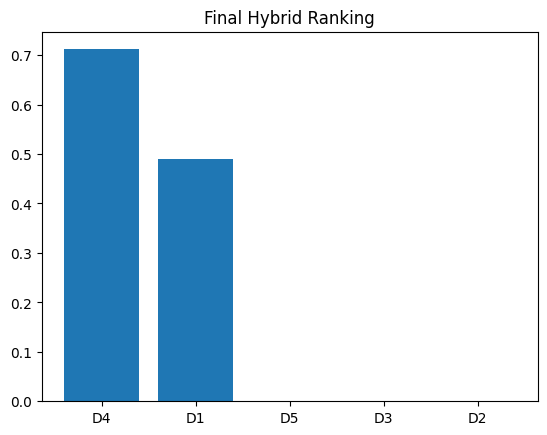

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# =========================
# DATA
# =========================
texts = [
    "LangChain helps build LLM applications.",
    "Pinecone is a vector database for semantic search.",
    "The Eiffel Tower is located in Paris.",
    "Langchain can be used to develop agentic ai application.",
    "Langchain has many types of retrievers."
]

query = "How can I build an application using LLMs?"

labels = [f"D{i+1}" for i in range(len(texts))]

# =========================
# VECTORIZATION
# =========================
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(texts)
q_tfidf = tfidf.transform([query])

# Dense simulation (semantic space)
svd = TruncatedSVD(n_components=5)
dense_docs = svd.fit_transform(X_tfidf)
dense_query = svd.transform(q_tfidf)

# =========================
# SIMILARITIES
# =========================
dense_sim = cosine_similarity(dense_query, dense_docs)[0]
sparse_sim = cosine_similarity(q_tfidf, X_tfidf)[0]
hybrid_sim = 0.7 * dense_sim + 0.3 * sparse_sim

# =========================
# 1) DENSE SPACE SCATTER
# =========================
pca = PCA(n_components=2)
all_dense = np.vstack([dense_docs, dense_query])
dense_2d = pca.fit_transform(all_dense)

plt.figure()
plt.scatter(dense_2d[:-1,0], dense_2d[:-1,1])
plt.scatter(dense_2d[-1,0], dense_2d[-1,1])
for i in range(len(labels)):
    plt.annotate(labels[i], (dense_2d[i,0], dense_2d[i,1]))
plt.annotate("QUERY", (dense_2d[-1,0], dense_2d[-1,1]))
plt.title("Dense Space (Semantic)")
plt.show()

# =========================
# 2) SPARSE SPACE SCATTER
# =========================
pca_sparse = PCA(n_components=2)
sparse_2d = pca_sparse.fit_transform(X_tfidf.toarray())

plt.figure()
plt.scatter(sparse_2d[:,0], sparse_2d[:,1])
for i in range(len(labels)):
    plt.annotate(labels[i], (sparse_2d[i,0], sparse_2d[i,1]))
plt.title("Sparse Space (BM25 / TF-IDF)")
plt.show()

# =========================
# 3) HYBRID SPACE
# =========================
svd_sparse = TruncatedSVD(n_components=5)
sparse_proj = svd_sparse.fit_transform(X_tfidf)

dense_norm = dense_docs / np.linalg.norm(dense_docs, axis=1, keepdims=True)
sparse_norm = sparse_proj / np.linalg.norm(sparse_proj, axis=1, keepdims=True)

hybrid_vecs = 0.7 * dense_norm + 0.3 * sparse_norm

pca_h = PCA(n_components=2)
hybrid_2d = pca_h.fit_transform(hybrid_vecs)

plt.figure()
plt.scatter(hybrid_2d[:,0], hybrid_2d[:,1])
for i in range(len(labels)):
    plt.annotate(labels[i], (hybrid_2d[i,0], hybrid_2d[i,1]))
plt.title("Hybrid Space (Dense + Sparse)")
plt.show()

# =========================
# 4) HYBRID HEATMAP
# =========================
plt.figure()
plt.imshow(hybrid_sim.reshape(1,-1))
plt.yticks([0], ["QUERY"])
plt.xticks(range(len(labels)), labels)
plt.title("Hybrid Similarity Heatmap")
plt.show()

# =========================
# 5) SCORE BARS
# =========================
x = np.arange(len(labels))

plt.figure()
plt.bar(x, dense_sim)
plt.xticks(x, labels)
plt.title("Dense Scores")
plt.show()

plt.figure()
plt.bar(x, sparse_sim)
plt.xticks(x, labels)
plt.title("Sparse Scores (BM25)")
plt.show()

plt.figure()
plt.bar(x, hybrid_sim)
plt.xticks(x, labels)
plt.title("Hybrid Scores")
plt.show()

# =========================
# 6) CONTRIBUTION
# =========================
plt.figure()
plt.bar(x, 0.7*dense_sim)
plt.xticks(x, labels)
plt.title("Dense Contribution")
plt.show()

plt.figure()
plt.bar(x, 0.3*sparse_sim)
plt.xticks(x, labels)
plt.title("Sparse Contribution")
plt.show()

# =========================
# 7) FINAL RANKING
# =========================
ranking = np.argsort(hybrid_sim)[::-1]

plt.figure()
plt.bar(range(len(ranking)), hybrid_sim[ranking])
plt.xticks(range(len(ranking)), [labels[i] for i in ranking])
plt.title("Final Hybrid Ranking")
plt.show()
